# Comparison of our method to VAEs on Flatland

1) Load relevant libraries

In [1]:
import os
import gym
import math
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

os.chdir('src/flatland/flat_game/')
from env import Env

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/william/.local/lib/python3.6/site-packages/pymunk/libchipmunk.so]


## Define environment

In [2]:
class FlatWorld():
    
    class action_space():
        def __init__(self,n_actions):
            self.n = n_actions
            
        def sample(self, k=1):
            return torch.randint(0,self.n,(k,))       

    class observation_space():
        def __init__(self):
            self.shape = [84,84]
    
    def __init__(self, env_parameters, period=10, radius=15):

        self.action_space = self.action_space(4)
        self.observation_space = self.observation_space()  
        self.period = period
        
        self.step_size = 0.1*(63-2*env_parameters['agent']['radius'])/period
        start_positions_list = [27 + 10*self.step_size*i for i in range(period)]
        self.start_positions = []
        for i in start_positions_list:
            for j in start_positions_list:
                self.start_positions.append((i,j))
                        
        env_parameters['agent']['radius'] = radius
        self.env = Env(**env_parameters)
        
    def reset(self, start_position=None):
        if start_position==None:
            obs = self.env.reset(position=random.sample(self.start_positions, 1)[0])
        else:
             obs = self.env.reset(position=start_position)
        return torch.FloatTensor(obs)/255
    
    def step(self, action):
        action_dict = self.create_action_dict(action)
        obs, reward, done, info = self.env.step(action_dict)
        return torch.FloatTensor(obs)/255
    
    def create_action_dict(self, action):
        action_dict = {}
        if action == 0:
            action_dict['longitudinal_velocity'] = 0
            action_dict['lateral_velocity'] = self.step_size
            action_dict['angular_velocity'] = 0
        if action == 1:
            action_dict['longitudinal_velocity'] = 0
            action_dict['lateral_velocity'] = -self.step_size
            action_dict['angular_velocity'] = 0
        if action == 2:
            action_dict['longitudinal_velocity'] = self.step_size
            action_dict['lateral_velocity'] = 0
            action_dict['angular_velocity'] = 0
        if action == 3:
            action_dict['longitudinal_velocity'] = -self.step_size
            action_dict['lateral_velocity'] = 0
            action_dict['angular_velocity'] = 0
        return action_dict
        

In [3]:
agent_parameters = {
    'radius': 15,
    'speed': 10,
    'rotation_speed' : math.pi/8,
    'living_penalty': 0,
    'position': (30,30),
    'angle': 0,
    'sensors': [
      
        {
           'nameSensor' : 'proximity_test',
           'typeSensor': 'proximity',
           'fovResolution': 64,
           'fovRange': 300,
           'fovAngle': math.pi ,
           'bodyAnchor': 'body',
           'd_r': 0,
           'd_theta': 0,
           'd_relativeOrientation': 0,
           'display': False,
        }
        
       
    ],
    'actions': ['forward', 'turn_left', 'turn_right', 'left', 'right', 'backward'],
    'measurements': ['health', 'poisons', 'fruits'],
    'texture': {
        'type': 'color',
        'c': (255, 255, 255)
    },
    'normalize_measurements': False,
    'normalize_states': False,
    'normalize_rewards': False
}

env_parameters = {
    'map':False,
    'n_rooms': 2,
    'display': False,
    'horizon': 10001,
    'shape': (84, 84),
    'mode': 'time',
    'poisons': {
        'number': 0,
        'positions': 'random',
        'size': 10,
        'reward': -10,
        'respawn': True,
        'texture': {
            'type': 'color',
            'c': (255, 255, 255),
        }
    },
    'fruits': {
        'number': 0,
        'positions': 'random',
        'size': 10,
        'reward': 10,
        'respawn': True,
        'texture': {
            'type': 'color',
            'c': (255, 150, 0),
        }
    },
    'obstacles': [
       
    ],
    'walls_texture': {
        'type': 'color',
        'c': (1, 1, 1)
    },
    'agent': agent_parameters
}

# Create Static Dataset

In [4]:
N_DATA = 10000
PERIOD=10
RADIUS=15

dataset = {}
env = FlatWorld(env_parameters, period=PERIOD, radius=RADIUS)
for i in tqdm(range(N_DATA)):
    state = env.step(np.random.randint(0,4))
    dataset[i] = state

100%|██████████| 10000/10000 [00:09<00:00, 1027.39it/s]


# Comparison to CCI-VAEs

**1) Define CCI-VAE**

Note: The following code derives from the pytorch repo on github https://github.com/pytorch/examples/blob/master/vae/main.py

In [8]:
class Encoder(nn.Module):

    def __init__(self, n_out=4, n_hid = 64, vmf=False):

        super().__init__()

        self.conv = nn.Conv2d(1, 5, 10, stride=3)
        self.fc1 = nn.Linear(180, n_hid)
        self.fc21 = nn.Linear(n_hid, n_out)
        if vmf:
            self.fc22 = nn.Linear(n_hid, 1)
        else:
            self.fc22 = nn.Linear(n_hid, n_out)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        x = F.relu(self.conv(x.unsqueeze(1)))
        x = F.max_pool2d(x, 4, 4)
        x = x.view(-1, 180)
        x = F.relu(self.fc1(x)).squeeze()
        return self.fc21(x), self.fc22(x)

class Decoder(nn.Module):
    
    def __init__(self, n_in=4, n_hid = 64):

        super().__init__()
        
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, 180)
        self.conv = nn.ConvTranspose2d(5, 1, 34, stride=10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1,5,6,6)
        x = self.conv(x)
        return torch.sigmoid(x).squeeze()

class CCIVAE(nn.Module):
    def __init__(self, latent_dim = 4, final_capacity=25, final_capacity_step=10000):
        super(CCIVAE, self).__init__()

        self.encoder = Encoder(n_out=latent_dim)
        self.decoder = Decoder(n_in=latent_dim)
        self.final_capacity = final_capacity
        self.final_capacity_step = final_capacity_step
        self.capacity = 0
        self.step = 0

    def encode(self, x):
        z, mu = self.encoder(x)
        return z, mu

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def update_capacity(self):
        if self.step < self.final_capacity_step:
            self.capacity += self.final_capacity/self.final_capacity_step
        self.step += 1
        return self.capacity
    
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, beta, capacity):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='mean')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta*torch.abs(KLD-capacity)

**2) CCI-VAE Main training loop**

In [6]:
LR = 1e-3
N_STEPS = 5000
BATCH_SIZE = 32
BETA = 1
LATENT_DIM = 4
FINAL_CAPACITY = 1
FINAL_CAPACITY_STEP = 5000

vae = CCIVAE(
    latent_dim = LATENT_DIM,
    final_capacity = FINAL_CAPACITY,
    final_capacity_step = FINAL_CAPACITY_STEP
)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR, weight_decay=0)

losses = []
capacities = []
for i in tqdm(range(N_STEPS)):
    
    batch = torch.stack(random.sample(list(dataset.values()), BATCH_SIZE))
    recon_batch, mu, logvar = vae(batch)
    capacity = vae.update_capacity()
    loss = loss_function(recon_batch, batch, mu, logvar, BETA, capacity)
    
    losses.append(loss.detach())
    capacities.append(capacity)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Loss on last batch was {}".format(loss.detach()))

100%|██████████| 5000/5000 [03:14<00:00, 25.07it/s]

Loss on last batch was 0.0657295435667038


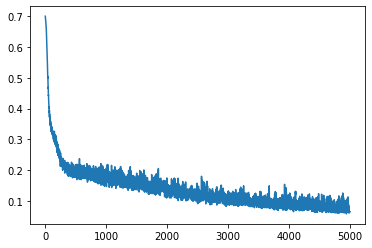

In [7]:
plt.plot(losses)

**3) Inspect learned representations**

First, check that the network can reconstruct the state

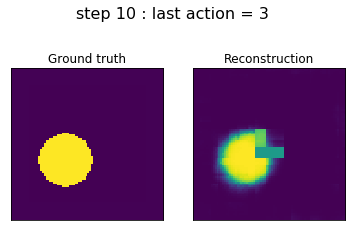

In [8]:
def plot_state(obs, ax):
    ax.imshow(obs)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 10

fig, (ax1,ax2) = plt.subplots(1, 2)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = env.reset()
    else:
        action = env.action_space.sample().item()
        obs_x = env.step(action)
        
    obs_z, _ = vae.encode(obs_x.unsqueeze(0))
    obs_x_recon = vae.decode(obs_z)
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

Now show representations in latent space

In [9]:
latent_points = []

for start_position in env.start_positions:
    obs = env.reset(start_position=start_position)
    latent, _ = vae.encode(obs)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


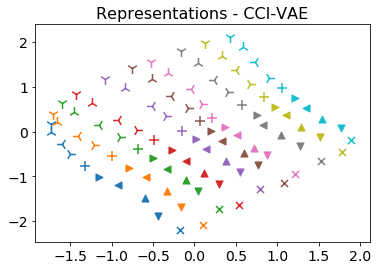

In [10]:
period = env.period

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b"]
marks=["1","2","3","4","+",">","<","^","v","x","d"]

main_dims = np.argsort(np.std(latent_map,axis=0))[-2:]
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)#, projection='3d')
s=[120]*5+[50]*6
for i in range (period**2):
    ax.scatter(x=latent_map[i,main_dims[0]],
                y=latent_map[i,main_dims[1]],
             #   zs=latent_2d.transpose()[2][i],
                c=color[i//period], 
                s=s[i%period],
                marker=marks[i%period])
 #   ax.set_xlim(-.6/1.4,.6/1.4)
  #  ax.set_ylim(-.8/1.4,.8/1.4)
  #  ax.set_zlim(-1./1.6,1./1.6)
    #ax.view_init(elev=45, azim=45)
plt.title('Representations - CCI-VAE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()
plt.savefig("ccivae.png", bbox_inches='tight')

# Comparison to hyperspherical VAEs

### 1) Define and train hyperspherical VAE

The following code derives from the pytorch repo on github https://github.com/nicola-decao/s-vae-pytorch

In [5]:
os.chdir('../../..')
from src.hyperspherical_utils import VonMisesFisher
from src.hyperspherical_utils import HypersphericalUniform

In [9]:
class HVAE(torch.nn.Module):
    
    def __init__(self, latent_dim=4, activation=F.relu, distribution='normal'):
        """
        ModelVAE initializer
        :param h_dim: dimension of the hidden layers
        :param latent_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(HVAE, self).__init__()
        
        self.latent_dim, self.activation, self.distribution = latent_dim, activation, distribution
        
        self.decoder = Decoder(n_in=latent_dim)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            self.encoder = Encoder(n_out=latent_dim)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            self.encoder = Encoder(n_out=latent_dim, vmf=True)
        else:
            raise NotImplemented

    def encode(self, x):
        # 2 hidden layers encoder
        
        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean, z_var = self.encoder(x)
            z_var = F.softplus(z_var)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean, z_var = self.encoder(x)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(z_var)+1
        else:
            raise NotImplemented
                                
        return z_mean, z_var
        
    def decode(self, z):
        
        return self.decoder(z)
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(self.latent_dim - 1)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        x_ = self.decode(z)
        
        return (z_mean, z_var), (q_z, p_z), z, x_
    

In [10]:
LR = 1e-3
N_STEPS = 5000
BATCH_SIZE = 32
LATENT_DIM = 4
DISTRIBUTION = 'vmf'
BETA=0.02

hvae = HVAE(latent_dim = LATENT_DIM, distribution = DISTRIBUTION)
optimizer = torch.optim.Adam(hvae.parameters(), lr=LR, weight_decay=0)

losses=[]
for i in tqdm(range(N_STEPS)):
    
    batch = torch.stack(random.sample(list(dataset.values()), BATCH_SIZE))
    
    _, (q_z, p_z), _, recon_batch = hvae(batch)
    loss_recon = F.binary_cross_entropy(recon_batch,batch)
    
    if hvae.distribution == 'normal':
        loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
    elif hvae.distribution == 'vmf':
        loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
    else:
        raise NotImplemented

    loss = loss_recon + BETA*loss_KL 
    
    losses.append(loss.detach())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Loss on last batch was {}".format(loss.detach()))

100%|██████████| 5000/5000 [03:32<00:00, 23.51it/s]

Loss on last batch was 0.1433420479297638


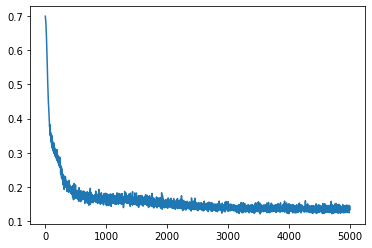

In [11]:
plt.plot(losses)

### 2) Check that the HVAE correctly reconstructs the state

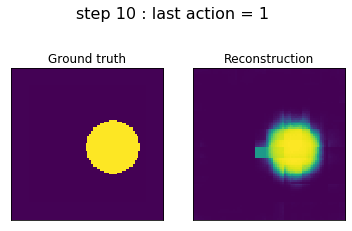

In [12]:
def plot_state(obs, ax):
    ax.imshow(obs)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax
    
n_steps = 10

fig, (ax1,ax2) = plt.subplots(1, 2)

ax1.set_title("Ground truth")
ax2.set_title("Reconstruction")

for i in range(n_steps+1):
    
    if i==0:
        action = "N\A"
        obs_x = env.reset()
    else:
        action = env.action_space.sample().item()
        obs_x = env.step(action)
        
    obs_z, _ = hvae.encode(obs_x.unsqueeze(0))
    obs_x_recon = hvae.decode(obs_z)
    
    #_, (q_z, p_z), _, obs_x_recon = hvae(obs_x.unsqueeze(0))
    
    fig.suptitle('step {} : last action = {}'.format(i, action), fontsize=16)
    
    plot_state(obs_x.detach().numpy(),ax1)
    plot_state(obs_x_recon.detach().numpy(),ax2)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
display.clear_output(wait=False)

### 3) Inspect learned representations

Random projections do not work well to visually inspect the representations. Instead, we remove the least important axis of the latent representations (determined by the std) and do a Hammer projection of the resulting 3D coordinates.

In [13]:
latent_points = []

for start_position in env.start_positions:
    obs = env.reset(start_position=start_position)
    latent, _ = hvae.encode(obs)
    latent_points.append(latent.detach().tolist())

latent_map = np.array(latent_points)

/home/william/Bureau/Projects/Article Robin/Code/src/flatland/flat_game/sensors/proximity_sensor.py:42: RuntimeWarning: invalid value encountered in not_equal
  mask = resized_img != 0


In [14]:
least_important_dim = latent_map.std(axis=0).argmin()
axes_to_select = []
for i in range(LATENT_DIM):
    if i != least_important_dim:
        axes_to_select.append(i)
latent_map = latent_map[:,axes_to_select]
                        
latitudes = np.pi/2-np.arccos(latent_map[:,2])
longitudes = np.arctan2(latent_map[:,0],latent_map[:,1])
new_z = np.sqrt(1+np.cos(latitudes)*np.cos(longitudes/2))
new_x = np.cos(latitudes) * np.sin(longitudes/2) / new_z
new_y = np.sin(latitudes) / new_z

/home/william/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


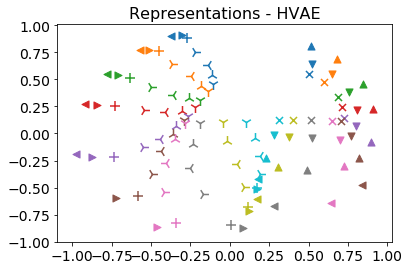

In [16]:
period = env.period

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',"#2fa36b"]
marks=["1","2","3","4","+",">","<","^","v","x","d"]
s=[120]*5+[50]*6
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
for i in range (period**2):
    ax.scatter(new_x[i],new_y[i],
                c=color[i//period], 
                s=s[i%period],
                marker=marks[i%period])
plt.title('Representations - HVAE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.show()
plt.savefig("hvae.png", bbox_inches='tight')